In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load the TSV file
df = pd.read_csv('ml-32m/ratings.csv')

# Print the head of the DataFrame
print(df.head())

   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


In [2]:
data_folder = './MovieSummaries/MovieSummaries/'
#paths to files
plot_summaries_path = data_folder + 'plot_summaries.txt'
movie_metadata_path = data_folder + 'movie.metadata.tsv'
character_metadata_path = data_folder + 'character.metadata.tsv'

# load the data
# 1. Plot summaries data
plot_summaries_df = pd.read_csv(plot_summaries_path, delimiter='\t', names=['wikipedia_movie_id', 'plot_summary'], 
                                 encoding='utf-8')

# 2. Movie metadata
movie_metadata_df = pd.read_csv(movie_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 
                                                                            'movie_name', 'release_date', 'box_office_revenue',
                                                                            'runtime', 'languages', 'countries', 'genres'], 
                                 encoding='utf-8')

# 3. Character metadata
character_metadata_df = pd.read_csv(character_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 
                                                                                    'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                                                                                    'actor_age_at_release', 'freebase_character_actor_map_id', 'freebase_character_id', 
                                                                                    'freebase_actor_id'], 
                                     encoding='utf-8')


In [3]:
movies = pd.read_csv('ml-32m/movies.csv')

In [4]:
print('Shape of ratings:', df.shape)

Shape of ratings: (32000204, 4)


In [5]:
movie_metadata_df['movie_name_formatted'] = movie_metadata_df['movie_name'].str.lower().str.strip()
movies['title_format'] = movies['title'].str[:-6].str.strip().str.lower()


In [6]:
# calculate the number of common movies between the two datasets

common_movies = set(movie_metadata_df['movie_name_formatted']).intersection(set(movies['title_format']))
print('Number of common movies:', len(common_movies))

# merge the two datasets

merged_df = pd.merge(movies, movie_metadata_df, left_on='title_format', right_on='movie_name_formatted', how='inner')

Number of common movies: 25632


In [7]:
merged_df

,movieId,title,genres_x,title_format,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres_y,movie_name_formatted
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toy story,53085,/m/0dyb1,Toy Story,1995-11-19,361958736.0,77.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0556j8"": ""Buddy film"", ""/m/03k9fj"": ""Adve...",toy story
1,2,Jumanji (1995),Adventure|Children|Fantasy,jumanji,3700174,/m/09w353,Jumanji,1995-12-15,262797249.0,104.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3n2k"": ""Fanta...",jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,grumpier old men,1934035,/m/0676dr,Grumpier Old Men,1995-12-22,71518503.0,101.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0556j8"": ""...",grumpier old men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,waiting to exhale,972970,/m/03vny7,Waiting to Exhale,1995-12-22,81452156.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/06w2n3t"": ...",waiting to exhale
4,5,Father of the Bride Part II (1995),Comedy,father of the bride part ii,3303622,/m/094g2z,Father of the Bride Part II,1995-12-08,76594107.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/02l7c8"": ...",father of the bride part ii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42632,292595,Ara (2008),Drama,ara,18884586,/m/04gm870,Ara,2008-03-21,NaN,89.0,"{""/m/02hwyss"": ""Turkish Language""}",{},"{""/m/07s9rl0"": ""Drama""}",ara
42633,292613,Freelance (2023),Action|Comedy,freelance,17041756,/m/0416k4n,Freelance,2007-03-01,NaN,63.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",freelance
42634,292613,Freelance (2023),Action|Comedy,freelance,17465733,/m/047f_x9,Freelance,1971,NaN,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada"", ""/m/07ssc"": ""United Ki...","{""/m/01jfsb"": ""Thriller""}",freelance
42635,292617,Comeback (2023),Comedy|Drama,comeback,19149310,/m/04lfcw_,Comeback,1982-04-23,NaN,105.0,"{""/m/02h40lc"": ""English Language"", ""/m/04306rv...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama""}",comeback


In [8]:
# Remove this user from the dataset, because it has too many ratings
df = df[df['userId'] != 175325]

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

def plot_user_genre_ratings(user_id, ratings_df, movies_genres_df):
    """
    Create histogram subplots of user ratings by genre.
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to analyze
    ratings_df : pandas.DataFrame
        DataFrame containing columns: user_id, movie_id, rating
    movies_genres_df : pandas.DataFrame
        DataFrame containing columns: movie_id, genres (pipe-separated string)
    """
    # Filter ratings for the specific user
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Merge with movies_genres to get genre information
    user_ratings_with_genres = user_ratings.merge(movies_genres_df, on='movieId')
    
    # Split the genres and explode to create separate rows for each genre
    user_ratings_with_genres['genres'] = user_ratings_with_genres['genres'].str.split('|')
    user_ratings_with_genres = user_ratings_with_genres.explode('genres')
    
    # Get unique genres
    unique_genres = user_ratings_with_genres['genres'].unique()
    
    # Calculate number of subplots needed
    n_genres = len(unique_genres)
    n_cols = 3
    n_rows = (n_genres + n_cols - 1) // n_cols
    
    # Create figure and subplots
    fig = plt.figure(figsize=(15, 4 * n_rows))
    fig.suptitle(f'Rating Distribution by Genre for User {user_id}', fontsize=16, y=1.02)
    
    # Create a subplot for each genre
    for idx, genre in enumerate(unique_genres, 1):
        genre_ratings = user_ratings_with_genres[user_ratings_with_genres['genres'] == genre]['rating']
        
        plt.subplot(n_rows, n_cols, idx)
        # Create histogram with centered bars
        plt.hist(genre_ratings, bins=np.arange(0.25, 5.75, 0.5), align='mid', 
                rwidth=0.8, color='skyblue', edgecolor='black')
                
        plt.title(f'{genre}\n(n={len(genre_ratings)} ratings)')
        plt.xlabel('Rating')
        plt.ylabel('Count')
    
    plt.tight_layout()
    return fig

def plot_ratings_by_release_year(user_id, ratings_df, movies_df):
    """
    Plot the distribution of movie release years for each rating value given by a user.
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to analyze
    ratings_df : pandas.DataFrame
        DataFrame containing columns: user_id, movie_id, rating
    movies_df : pandas.DataFrame
        DataFrame containing columns: movie_id, release_year
    """
    # Filter ratings for the specific user
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Merge with movies to get release year information
    user_ratings_with_year = user_ratings.merge(movies_df, on='movieId')
    
    # Get unique rating values
    unique_ratings = sorted(user_ratings_with_year['rating'].unique())
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Color map for different ratings
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_ratings)))
    
    # Plot a smoothed line for each rating
    for rating, color in zip(unique_ratings, colors):
        # Get release years for this rating
        years = pd.to_datetime(user_ratings_with_year[user_ratings_with_year['rating'] == rating]['release_date'], format='%Y-%m-%d', errors='coerce')
        # Get the year from the date
        years = years.dt.year.dropna()
        
        if len(years) > 1:  # Need at least 2 points for kde
            # Create kernel density estimate
            
            kernel = gaussian_kde(years)
            
            # Create year range for smooth plot
            year_range = np.linspace(years.min(), years.max(), 100)
            
            # Plot smoothed line
            density = kernel(year_range)
            # Scale density to make it more visible
            #density = density * len(years) * 2  # Scale factor can be adjusted
            
            plt.plot(year_range, density, label=f'Rating {rating:.1f} (n={len(years)})',
                    color=color, linewidth=2)
            
            # Add scatter plot of actual points
            plt.scatter(years, np.zeros_like(years), color=color, alpha=0.2,
                       marker='|', s=100)
    
    # Customize the plot
    plt.title(f'Distribution of Movie Release Years by Rating for User {user_id}')
    plt.xlabel('Release Year')
    plt.ylabel('Density')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Alternative version using histogram instead of KDE
def plot_ratings_by_release_year_histogram(user_id, ratings_df, movies_df, bin_width=5):
    """
    Plot histogram of movie release years for each rating value given by a user.
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to analyze
    ratings_df : pandas.DataFrame
        DataFrame containing columns: user_id, movie_id, rating
    movies_df : pandas.DataFrame
        DataFrame containing columns: movie_id, release_year
    bin_width : int
        Width of the histogram bins in years
    """
    # Filter ratings for the specific user
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    # Merge with movies to get release year information
    user_ratings_with_year = user_ratings.merge(movies_df, on='movieId')
    
    # Get unique rating values
    unique_ratings = sorted(user_ratings_with_year['rating'].unique())
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Calculate bin edges
    user_ratings_with_year['release_date'] = pd.to_datetime(user_ratings_with_year['release_date'], format='%Y-%m-%d', errors='coerce')
    
    min_year = user_ratings_with_year['release_date'].dt.year.min()
    max_year = user_ratings_with_year['release_date'].dt.year.max()

    bins = np.arange(min_year - (min_year % bin_width), 
                    max_year + bin_width - (max_year % bin_width) + 1, 
                    bin_width)
    
    # Color map for different ratings
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_ratings)))
    
    # Plot histograms for each rating
    for rating, color in zip(unique_ratings, colors):
        years = pd.to_datetime(user_ratings_with_year[user_ratings_with_year['rating'] == rating]['release_date'], format='%Y-%m-%d', errors='coerce')
        
        plt.hist(years, bins=bins, alpha=0.5, label=f'Rating {rating:.1f} (n={len(years)})',
                color=color, histtype='step', linewidth=2, density=True)
        
        # Add scatter plot of actual points
        plt.scatter(years, np.zeros_like(years), color=color, alpha=0.2,
                   marker='|', s=100)
    
    # Customize the plot
    plt.title(f'Distribution of Movie Release Years by Rating for User {user_id}')
    plt.xlabel('Release Year')
    plt.ylabel('Density')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return plt.gcf()

In [10]:
# Print the user with the most ratings
user_ratings_count = df['userId'].value_counts()

print('User with the most ratings:')
print(user_ratings_count.head(20))


User with the most ratings:
userId
17035     9577
55653     9178
123465    9044
171795    9016
10202     7748
198515    7594
49305     7488
22744     7372
7858      7322
14674     6407
53192     6265
133878    6074
57304     6061
129705    5812
139018    5806
43703     5784
68797     5693
103925    5655
119247    5654
8588      5649
Name: count, dtype: int64


In [24]:
user_ratings_count.index[1000]

np.int64(199143)

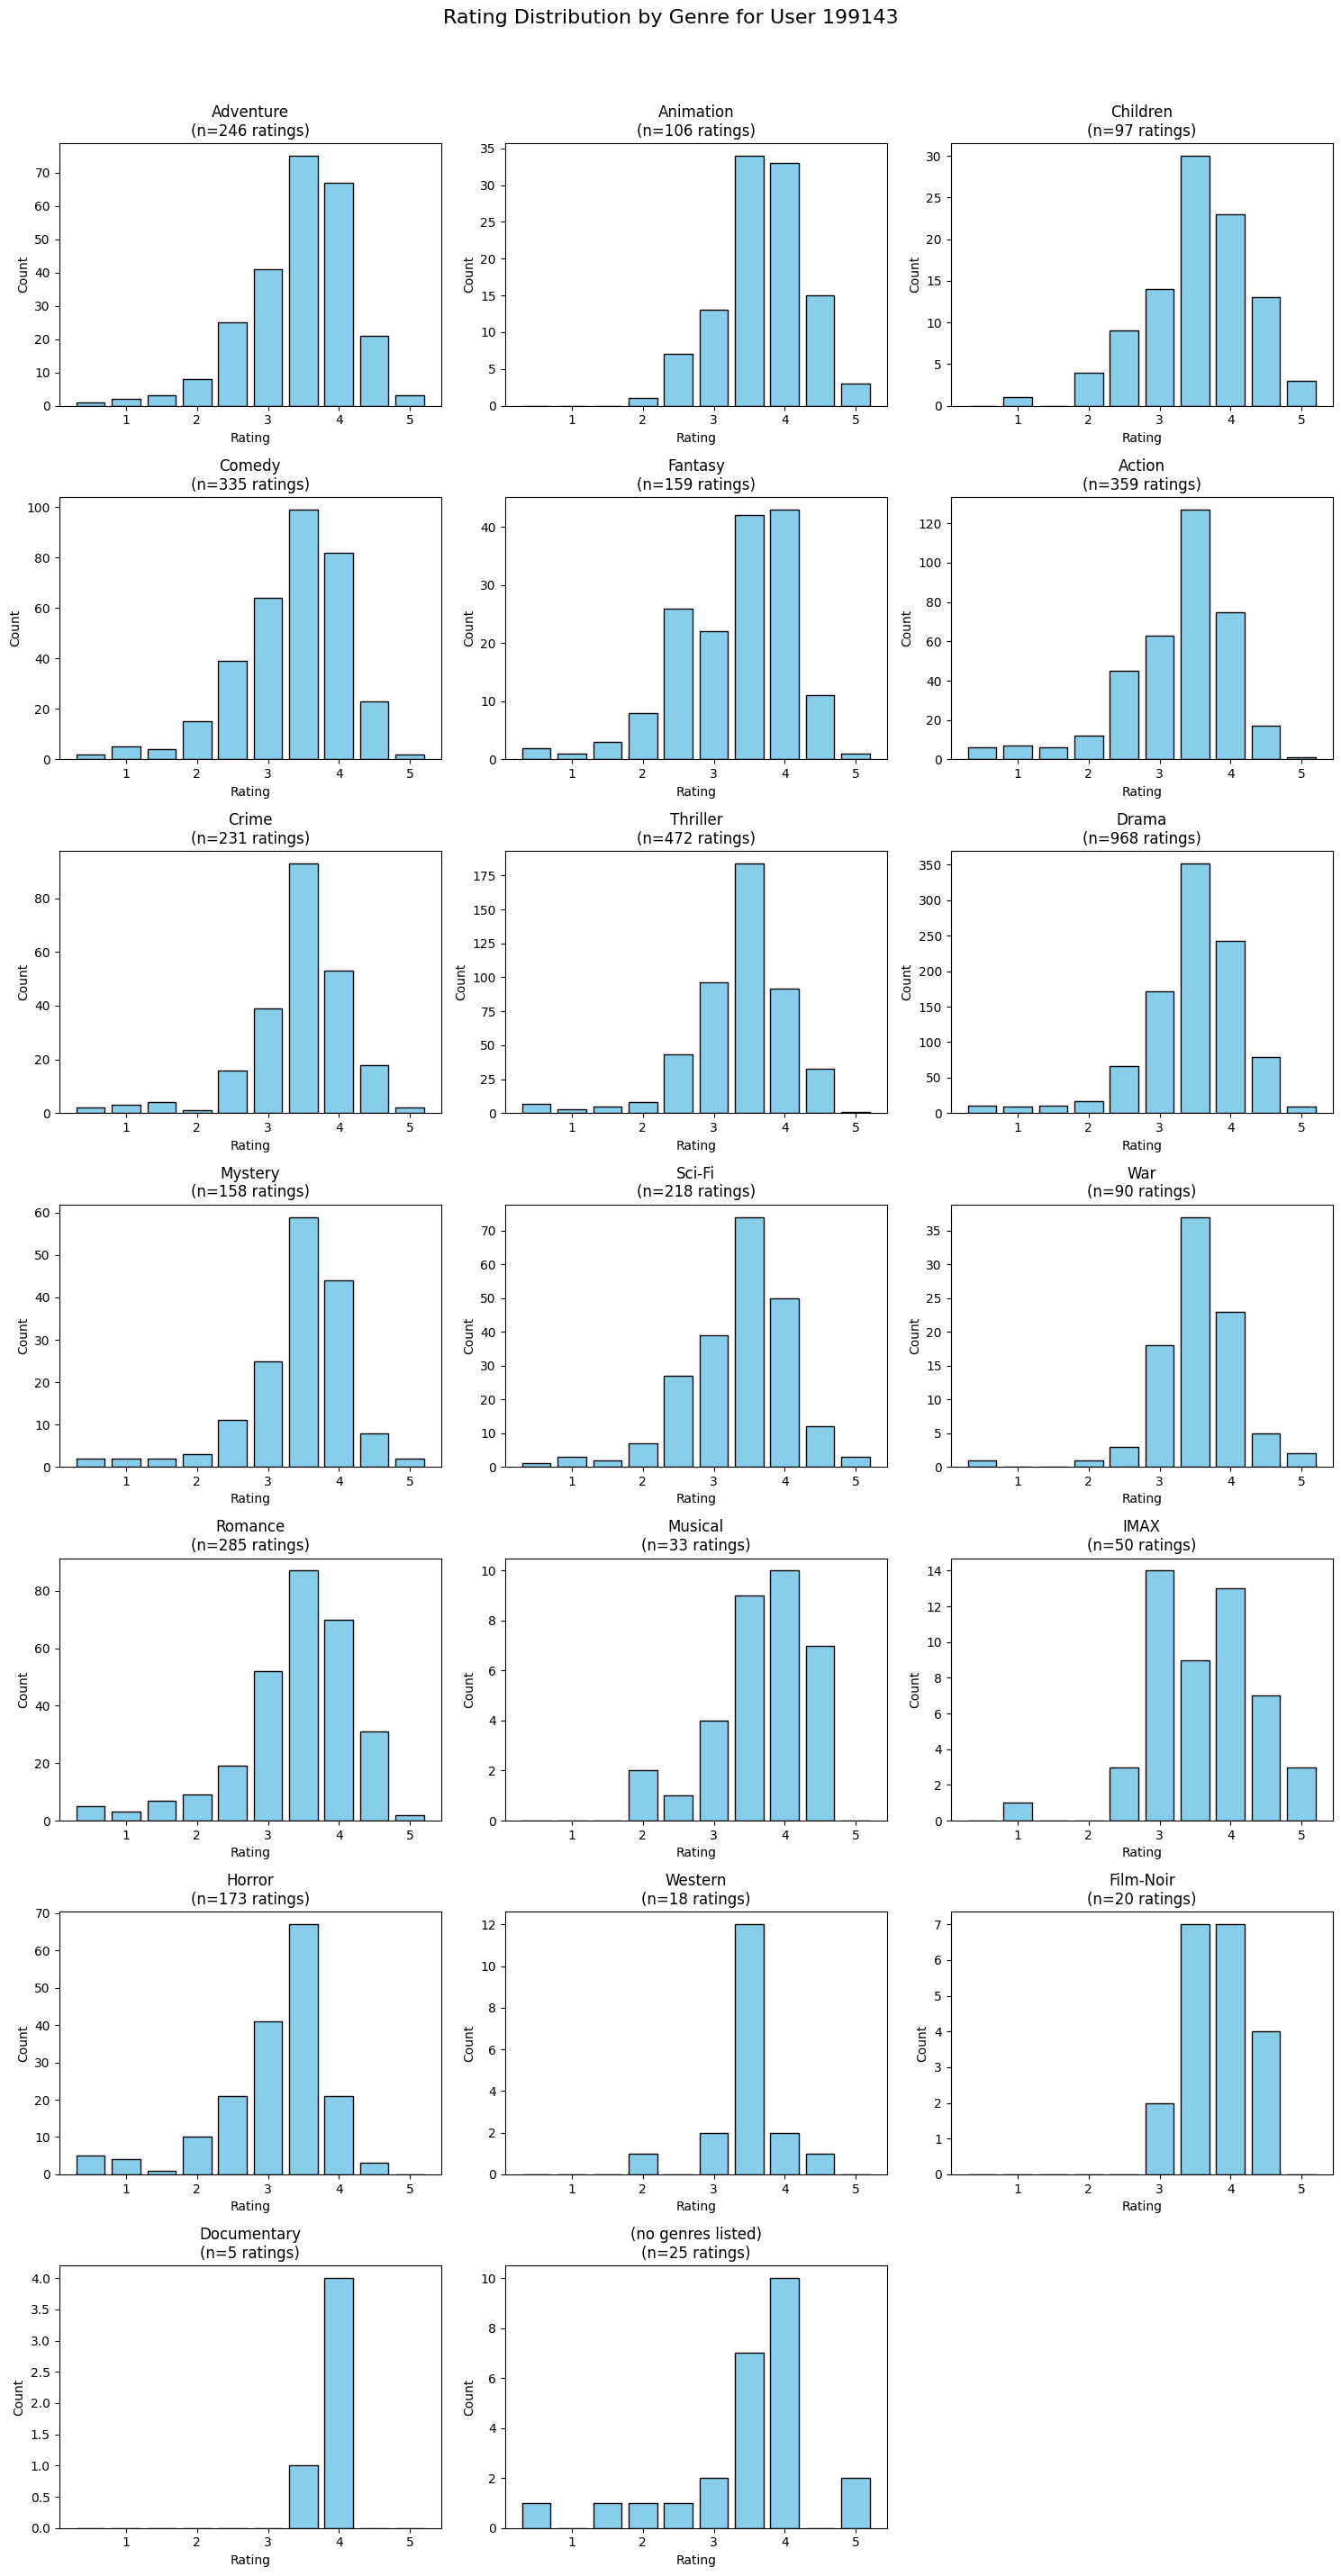

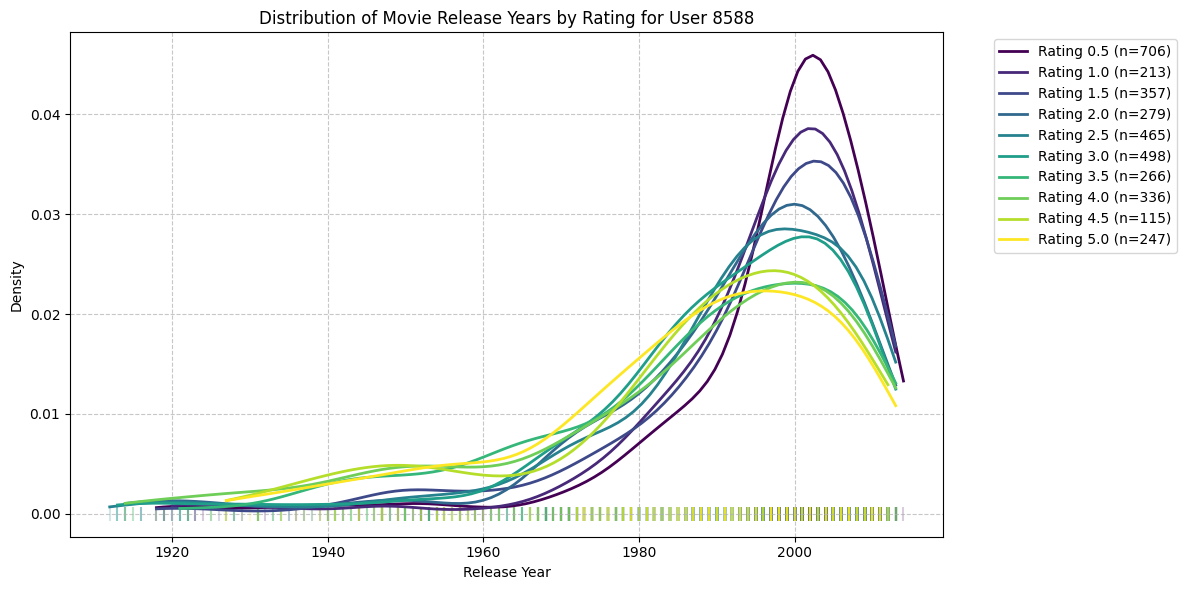

In [25]:
fig1 = plot_user_genre_ratings(199143, df, movies)
plt.show()

fig2 = plot_ratings_by_release_year(8588, df, merged_df)
plt.show()

In [ ]:
# Filter users by minimum number of ratings to reduce matrix size
min_ratings = 1000  # adjust this as needed
user_counts = df['userId'].value_counts()
valid_users = user_counts[user_counts >= min_ratings].index

# Filter the dataframe to only include these users
filtered_df = df[df['userId'].isin(valid_users)]

# Create the sparse matrix using pivot_table instead of pivot
# pivot_table is generally more memory efficient
ratings_matrix = filtered_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=None  # or use 0 if you prefer
)

# Optional: you can convert to sparse if still too large
# from scipy.sparse import csr_matrix
# sparse_ratings = csr_matrix(ratings_matrix)

print(f"Matrix shape: {ratings_matrix.shape}")
print(f"\nPreview of ratings matrix:")
print(ratings_matrix.iloc[:5, :5])  # Show first 5 users and 5 movies

In [14]:
a = (~ratings_matrix.isna()).sum(axis=1).sort_values(ascending=False)

In [ ]:
n = 1000  # You can change this value to your desired threshold

# Group by userId and count the number of ratings for each user
user_rating_counts = df.groupby('userId').size()

# Filter users with more than n ratings
users_with_more_than_n_ratings = user_rating_counts[user_rating_counts > n]

# Print the number of users with more than n ratings
print(f"Number of users with more than {n} ratings: {len(users_with_more_than_n_ratings)}")

In [5]:
# Filter the dataframe to include only users with more than n ratings
filtered_df = df[df['userId'].isin(users_with_more_than_n_ratings.index)]

# Create a user-item matrix
user_item_matrix = filtered_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
ratings_matrix = df.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    )


In [6]:
#Standardize the matrix before pca

scaler = StandardScaler()
user_item_matrix_pca = scaler.fit_transform(user_item_matrix)


In [10]:



# Apply PCA
m = 2  # Number of principal components
pca = PCA(n_components=m)
pca_result = pca.fit_transform(user_item_matrix_pca)

# Get the components of the PCA
components = pca.components_


In [ ]:

# Get the indices of the movies that have the highest absolute values in the first component
most_influential_movies_indices = components[0].argsort()[-10:][::-1]

# Get the movie IDs of the most influential movies
most_influential_movies = user_item_matrix.columns[most_influential_movies_indices]

print("Movies that influence the most on PCA on the ratings:")
print(most_influential_movies)

In [ ]:
movies[movies['movieId'].isin(most_influential_movies)]

In [ ]:
user_item_matrix_pca.shape

In [ ]:
import matplotlib.pyplot as plt

# Plot the PCA
plt.figure(figsize=(10, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.1)
plt.xlim([-10, 10])
plt.ylim([-10, 10])